In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

# Cavity Exercise Simulation

In this exercise we are loking at a vacuum cavity withing a material. We want to calculate/simulate
the neutorn flux as a funtion of the distance from the center of the cavity.

In this simulation we will:
1. Create a sphere fill it with nothing
2. Create a bigger sphere and fill it with a random yet suitable material(aluminum)
3. Add a source in the center
4. Simulate the case

## Geometries

In [2]:
R=10 #Radius of cavity

In [3]:
cavity = openmc.Sphere(r=R) # Create the spherical cavity
exp = openmc.Sphere(r=20,boundary_type='vacuum') #Larger sphere to have material region

## Materials

In [4]:
# Create the material (Aluminum)
al = openmc.Material()
al.add_element('aluminum',1.0)

In [5]:
# Add our material to the material list
mats = openmc.Materials([al])
mats.export_to_xml()

# Cell Regions

In [6]:
cell = openmc.Cell()
cell.region = +cavity & -exp
cell.fill = al

In [7]:
cav = openmc.Cell()
cav.region = -cavity

## Universe

In [8]:
uni = openmc.Universe()
uni.add_cell(cell)
uni.add_cell(cav)

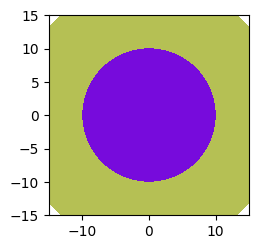

In [9]:
uni.plot(width=(30, 30), origin=(0.0, 0.0, 0.0))

In [10]:
#Export the geometry
geometry = openmc.Geometry(uni)
geometry.export_to_xml()

In [11]:
# Create a point source of neutrons
point = openmc.stats.Point((0, 0, 0))
source = openmc.Source(space=point,energy=openmc.stats.Uniform(10,10))

## Simulation Settings

We define the settings for the simulatoins:
- 100 batches of 10k particles
- fixed source (we are not looking at fusion or anything, just a fixed neutron source)

In [12]:
settings = openmc.Settings()
settings.source = source
settings.batches = 100
settings.particles = 10_000
settings.run_mode = 'fixed source'
settings.export_to_xml()

Nex we need to define the output we want. That is we define the tallies that openmc should generate for us.

We want the flux at different points withing our universe so we create a meshgrid:

In [13]:
mesh = openmc.RegularMesh()
mesh.dimension = [200, 200]
mesh.lower_left = [-20, -20]
mesh.upper_right = [20, 20]
xmin=mesh.lower_left[0]
xmax=mesh.upper_right[0]
ymin=mesh.lower_left[1]
ymax=mesh.upper_right[1]
N=mesh.dimension[0]
xs,ys = np.meshgrid(np.linspace(xmin,xmax,N),np.linspace(ymin,ymax,N))
# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)

We create the tally object, specify our grid and that we want the flux tally.

In [14]:
tal = openmc.Tally()
tal.scores = ['flux']
tal.filters = [mesh_filter]
tallies = openmc.Tallies([tal])
tallies.export_to_xml()

We remove any old simulation result and then run openmc

In [15]:
!rm -rf summary.h5
!rm -rf statepoint.100.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Results

We are now ready to look at the results.

We load in the result file pick and pick out our flux tallies. We then reshape them to match the
grid we specified earlier:

In [16]:
sp = openmc.StatePoint('statepoint.100.h5')
tally = sp.get_tally(scores=['flux'])
flux = tally.get_slice(scores=['flux'])
flux.mean.shape = (200,200)

We then define the theoretical flux function from the solution to 5.8:

In [17]:
def theory(x):
    #Disclaimer: Constants derived using sliderule
    A=0.035
    k=0.36
    phi = lambda r: A*(1/(r)) if r<R else A*(1/r)*np.exp(-k*(r-R))
    return list(map(phi,x))

Finally we plot the results:

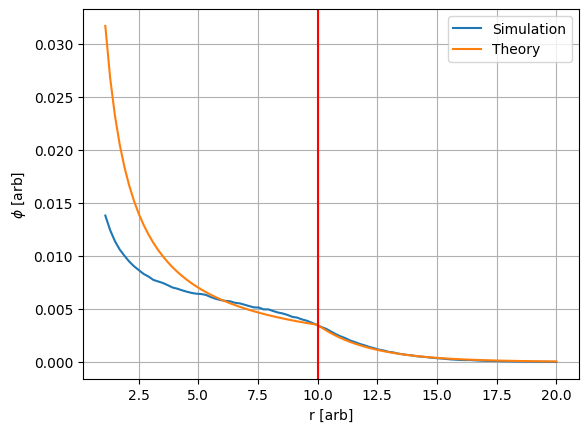

In [22]:
L=105 #Plitting limit
plt.plot(xs[100,L:],flux.mean[100,L:],label="Simulation")
plt.plot(xs[100,L:],theory(xs[100,L:]),label="Theory")
plt.axvline(x=R,c='r')
plt.grid(which='both')
plt.xlabel('r [arb]')
plt.ylabel(r'$\phi$ [arb]')
plt.legend()

And a filled contour of the simulatoin:

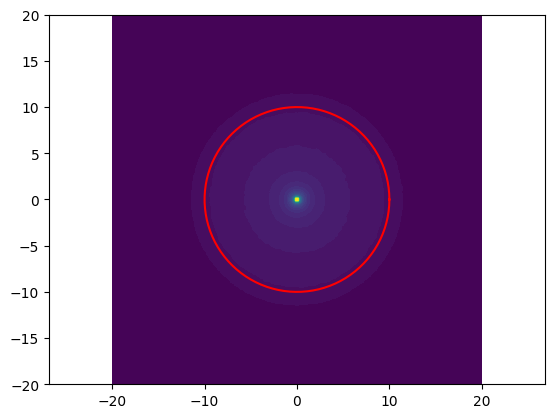

In [27]:
plt.contourf(xs,ys,flux.mean,50)
plt.axis('equal')

th = np.linspace(0,2*np.pi,100)
cxs = R*np.cos(th)
cys = R* np.sin(th)
plt.plot(cxs,cys,'r-')